# Домашняя работа: "Методы оптимизации"

ФИО: Будин Владислав Евгеньевич

## Описание задания:
Вам необходимо реализовать оставшиеся методы оптимизации, которые разбирались на лекции: <b>Momentum, AdaDelta, Adam</b>. Сравнение методов оптимизации нужно провести на примере из семинара, а также при обучении сверточной нейронной сети на датасете MNIST.



## Задание разделено на следующие части:
1.1 Реализация методов Momentum, AdaDelta, Adam **(1 балл)**

1.2 Сравнение реализованных методов **(1 балл)**

2.1 Реализация сверточной нейронной сети и обучение ее на MNIST **(2 балла)**

2.2 Сравнение графиков обучения для нейросети на реализованных методах **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 9 октября.

In [1]:
from functools import partial
import sys
import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
from IPython.display import clear_output
%matplotlib inline
plt.rc('animation', html='html5')

/home/vlad/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Часть 1: Реализация методов

In [2]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

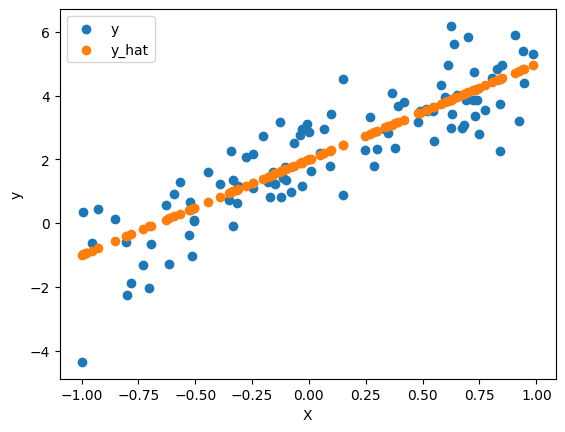

In [3]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

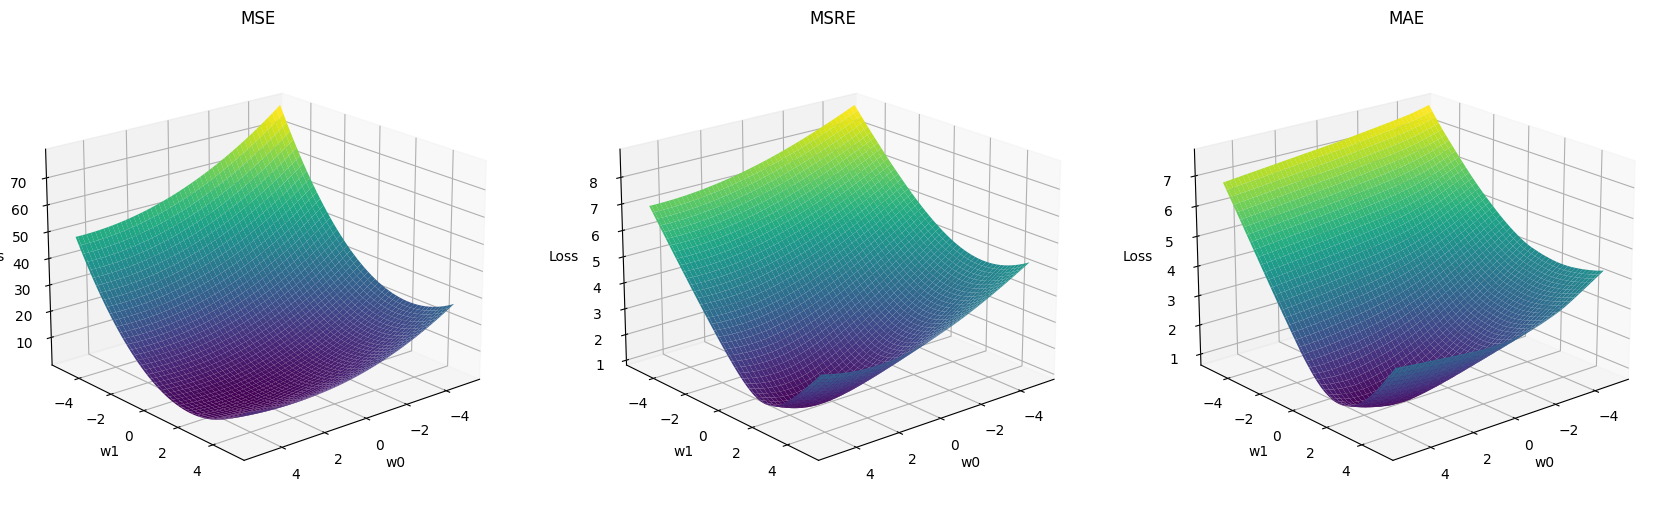

In [4]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [5]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [6]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [7]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

Реализация методов SGD и AdaGrad с семинара:

In [8]:
class SGD(Optimizer):
    def __init__(self, params={}, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad

In [9]:
class AdaGrad(Optimizer):
    def __init__(self, params={}, eta=1e-8, nu=1e-2):
        super().__init__(params)
        self.eta = eta
        self.nu = nu

        self.G = [0] * len(self.params)

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] += p.grad ** 2

                p -= self.nu / torch.sqrt(self.G[i] + self.eta) * p.grad

### 1.1 Реализуйте методы Momentum, AdaDelta, Adam. **(1 балл)**

#### Momentum
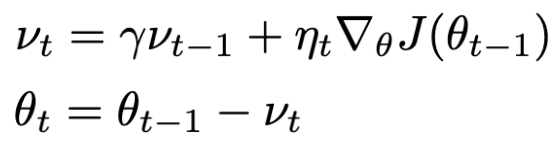

In [10]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma
        self.momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.momentum[i] = self.gamma * self.momentum[i] + self.lr * p.grad
                p -= self.momentum[i]

#### AdaDelta
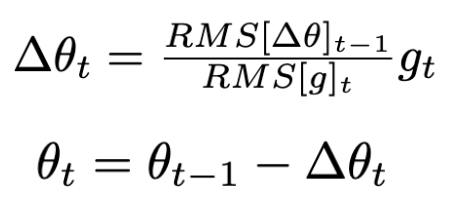

In [11]:
class AdaDelta(Optimizer):
    def __init__(self, params={}, eta=1e-8, gamma=0.9, delta_start=0.001):
        super().__init__(params)
        self.eta = eta
        self.gamma = gamma
        self.G = [torch.zeros(p.shape) for p in self.params]
        self.O = [torch.ones(p.shape) * delta_start for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * p.grad**2
                dp = torch.sqrt(self.O[i] + self.eta) / torch.sqrt(self.G[i] + self.eta) * p.grad
                self.O[i] = self.gamma * self.O[i] + (1 - self.gamma) * dp**2
                p -= dp

#### Adam
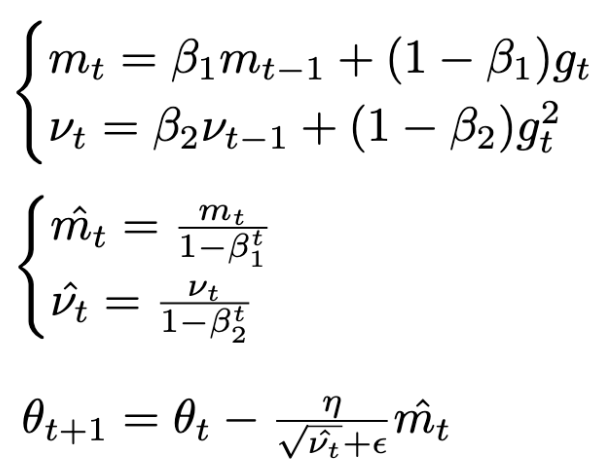

In [12]:
class Adam(Optimizer):
    def __init__(self, params, lr=1e-2, b1 = 0.9, b2 = 0.9, eta=1e-8):
        super().__init__(params)
        self.lr = lr
        self.b1 = b1
        self.b2 = b2
        self.eta = eta
        self.momentum = [torch.zeros(p.shape) for p in self.params]
        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.momentum[i] = self.b1 * self.momentum[i] + (1 - self.b1) * p.grad
                self.G[i] = self.b2 * self.G[i] + (1 - self.b2) * p.grad**2

                m_corrected = self.momentum[i] / (1 - self.b1)
                G_corrected = self.G[i] / (1 - self.b2)
                p -= self.lr * m_corrected / (torch.sqrt(G_corrected) + self.eta)

### 1.2 Сравните реализованные методы на предложенном примере **(1 балл)**

In [13]:
from functools import partial

points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), AdaDelta, {'eta': 1e-8}, start_point=[-4, -4], num_iter=100)

In [14]:
compare_optimizers(
    loss_animator,
    mse,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['Momentum', Momentum, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'eta': 1e-8, 'nu' : 1}],
        ['AdaDelta', AdaDelta, {'gamma': 0.9, 'eta': 1e-8, 'delta_start': 0.1}],
        ['Adam', Adam, {'eta': 1e-8, 'lr': 1e-1}],
     ],
    start_point=[-4, -4],
    num_iter=100
)

##### 1. Лучше всего показал себя оптимизатор AdaDelta. Движение происходило без колебаний по прямой к оптимуму и показало самую высокую скорость сходимости.

##### 2-3. SGD и AdaGrad показали схожую скорость сходимости, но Adagrad двигался прямо, а SGD по дуге. Adagrad оказался медленнее, чем Adadelta из-за затухания градиентов. Adagrad, в отличие, от SGD регулирует скорость обучения, поэтому траектория оказалась прямой.

##### 4-5. Momentum и Adam сходились дольше всего. Они перескакивали оптимум из-за сохранения момента. Momentum был больше подвержен заносам, тогда как Adam поначалу двигался довольно прямо.

##  Часть 2: Обучение нейронной сети

### 2.1 Реализуйте сверточную нейронную сеть и обучите ее на MNIST с помощью методов Adam, Adagrad, AdaDelta и SGD. Для обучения используйте оптимизаторы из первой части, а не из pytorch. **(2 балла)**

Скачайте датасет и реализуйте даталоудеры:

In [15]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2023-10-16 18:18:10--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 

129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2023-10-16 18:18:10--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [     <=>            ]  33.20M  5.90MB/s    in 5.7s    

2023-10-16 18:18:16 (5.81 MB/s) - ‘MNIST.tar.gz.1’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/train-images-idx3-ubyte.gz
MNIST/processed/
MNIST/processed/training.pt
MNIST/processed/test.pt


In [16]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

Реализуйте сверточную нейронную нейронную сеть по шаблону:

* Используйте сверточные (nn.Conv2d) и полносвязные (nn.Linear) слои
* Не забудьте преобразовать тензор перед подачей в полносвязный слой (x = x.view(-1, d1), где d1 -- размерность входа первого полносвязного слоя)
* Можно использовать dropout (nn.Dropout2d) и функции активации (например, F.relu)
* В конце метода forward необходимо использовать F.log_softmax для предсказания класса изображения

In [17]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.linear1 = nn.Linear(4*4*64, 128)
        self.linear2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, stride=2)
        x = x.view(-1, 4*4*64)
        x = self.linear1(x)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)

Запустите обучение, постройте график лоссов от эпохи:

In [18]:
def train(models, names, optimizers, loss_fn, n_epochs=5, plot=True, verbose=True):
    n = len(models)
    models_train_losses_epochs = [list() for i in range(n)]
    models_val_losses_epochs = [list() for i in range(n)]

    for model in models:
        model.train()
    for epoch in range(n_epochs):
        models_losses = [list() for i in range(n)]
        # обучение
        for batch_idx, (images_train, labels_train) in enumerate(tqdm(train_loader)):
            X = images_train.data
            y = labels_train.data
            for i in range(n):
                output = models[i](X)
                loss = loss_fn(output, y)
                models_losses[i].append(loss.detach())
                loss.backward()
                optimizers[i].step()
                optimizers[i].zero_grad()
        
        for i in range(n):
            models_train_losses_epochs[i].append(np.mean(models_losses[i]))
        
        # валидация
        models_losses = [list() for i in range(n)]
        with torch.no_grad():
            for batch_idx,(images_test, labels_test) in enumerate(test_loader):
                X = images_test.data
                y = labels_test.data
                for i in range(n):
                    output = models[i](X)
                    loss = loss_fn(output, y)
                    models_losses[i].append(loss)

        for i in range(n):
            models_val_losses_epochs[i].append(np.mean(models_losses[i]))
        
        clear_output(True)
        # if verbose:
        #     sys.stdout.write('\rEpoch {0}... ({1} Train/Test): {2:.3f}/{3:.3f}\t({4} Train/Test): {5:.3f}/{6:.3f}'.format(
        #                 epoch, name1, model1_train_loss_epochs[-1], model1_val_loss_epochs[-1], name2,
        #                 model2_train_loss_epochs[-1], model2_val_loss_epochs[-1]))
        if plot:
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            for i in range(n):
                plt.plot(models_train_losses_epochs[i], label=names[i])
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Train Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid('on')
            plt.subplot(1, 2, 2)
            for i in range(n):
                plt.plot(models_val_losses_epochs[i], label=names[i])
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Test Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid('on')
            plt.show()


In [19]:
nets = [Net() for i in range(5)]
sgd = SGD(params=nets[0].parameters())
momentum = Momentum(params=nets[1].parameters())
adagrad = AdaGrad(params=nets[2].parameters())
adadelta = AdaDelta(params=nets[3].parameters(), delta_start=0)
adam = Adam(params=nets[4].parameters(), lr=1e-3, b1=0.9, b2=0.999)
optimizers = [sgd, momentum, adagrad, adadelta, adam]
names = ['SGD', 'Momemntum', 'AdaGrad', 'AdaDelta', 'Adam']
loss_fn = torch.nn.NLLLoss()

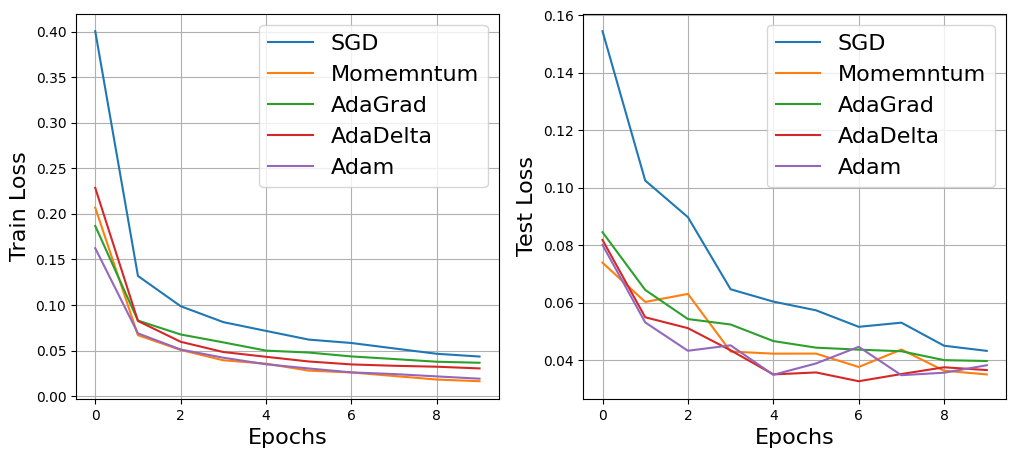

In [20]:
train(nets, names, optimizers, loss_fn, n_epochs=10)

### 2.2 Сравните графики обучения для нейросети на методах Adam, Adagrad, AdaDelta и SGD. **(1 балл)**

По результатам обучения дольше всего сходится SGD. Дальше по скорости идёт AdaGrad. Но так как у него нет момента, сходимость была без сильных колебаний. Momentum и Adam показали похожее поведение: они имеют более сильные колебания, но достигли качетсва лучше SGD и AdaGrad. AdaDelta удалось показать наилучшее качество без больших колебаний.